# Attention
 
注意力机制通过注意力汇聚将查询(自主性提示)和键(非自主性提示)结合在一起，实现对值(感 官输入)的选择倾向。
 
![title](attachment/attention.png)

ps：


pip install d2l

pip install matplotlib==3.0.0

In [1]:
import os
import math
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import collections
import re
import numpy as np

## Nadaraya-Watson 核回归

- 平均汇聚
$$
f（x） = \frac{1}{n}\sum_iy_i
$$

- Nadaraya-Watson 核回归
$$
f（x） = \sum_i^n\frac{K(x-x_i)}{\sum_j K(x-x_j)}y_i \quad s.t.K是核（kernel）
$$


假设使用高斯核：$K(\mu) = \frac{1}{\sqrt{2\pi}}e^{-\frac{u_2}{2}}$


$$
\begin{align}
f（x） &= \sum_i^n\frac{exp(-\frac{1}{2}(x-x_i)^2)}{\sum_j exp(-\frac{1}{2}(x-x_j)^2)}y_i\\
&=  \sum_i^nsoftmax(-\frac{1}{2}(x-x_i)^2)y_i
\end{align}
$$

- 带参数注意⼒汇聚

⾮参数的Nadaraya-Watson核回归具有⼀致性（consistency）的优点：如果有⾜够的数据，此模型会收敛到
最优结果。尽管如此，我们还是可以轻松地将可学习的参数集成到注意⼒汇聚中。

$$
\begin{align}
f（x） &= \sum_i^n\frac{exp(-\frac{1}{2}w(x-x_i)^2)}{\sum_j exp(-\frac{1}{2}w(x-x_j)^2)}y_i\\
&=  \sum_i^nsoftmax(-\frac{1}{2}w(x-x_i)^2)y_i
\end{align}
$$


In [2]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train)*5)

def f(x):
  return 2*torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # 训练样本的输出
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test) # 测试样本数
n_test

50

In [3]:
def plot_kernel_reg(y_hat):
  d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
          xlim=[0, 5], ylim=[-1, 5])
  d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

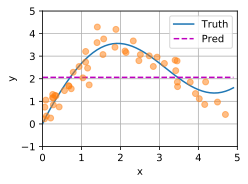

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

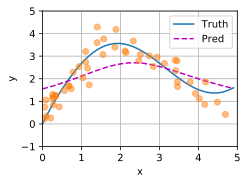

In [5]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

## Attention Scoring Function
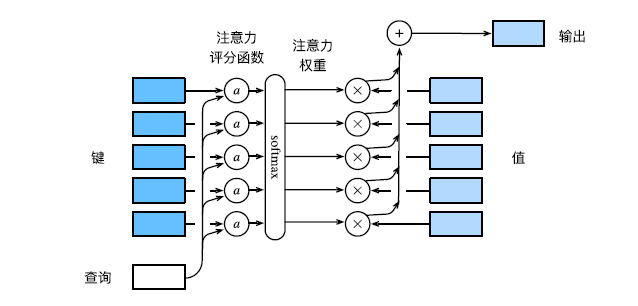



⽤数学语⾔描述，假设有⼀个查询$\pmb q \in \mathbb R^q $ 2 和m个“键－值”对$(\pmb k_1; \pmb v_1),...,(\pmb k_m; \pmb v_m)$，其中$\pmb k_i \in \mathbb R^k $，$\pmb v_i \in \mathbb R^v $。

注意⼒汇聚函数f就被表⽰成值的加权和：
$$
f(\pmb q,(\pmb k_1; \pmb v_1),...,(\pmb k_m; \pmb v_m)) = \sum_i^m\alpha(\pmb q, \pmb k_i)\pmb v_i\\
$$

- masked softmax operation
$$
\alpha(\pmb q; \pmb k_i) = softmax(\alpha(\pmb q, \pmb k_i))
$$



In [6]:
torch.repeat_interleave(torch.tensor([2, 3]), 2)

tensor([2, 2, 3, 3])

In [7]:
def sequence_mask(X, valid_len, value=0):
  """在序列中屏蔽不相关的项"""
  maxlen = X.size(1)
  mask = torch.arange((maxlen), dtype=torch.float32,
          device=X.device)[None, :] < valid_len[:, None]
  X[~mask] = value
  return X

def masked_softmax(X, valid_lens):
  """通过在最后⼀个轴上掩蔽元素来执⾏softmax操作"""
  # X:3D张量，valid_lens:1D或2D张量
  if valid_lens is None:
    return nn.functional.softmax(X, dim=-1)
  else:
    shape = X.shape
  if valid_lens.dim() == 1:
    valid_lens = torch.repeat_interleave(valid_lens, shape[1])
  else:
    valid_lens = valid_lens.reshape(-1)
  # 最后⼀轴上被掩蔽的元素使⽤⼀个⾮常⼤的负值替换，从⽽其softmax输出为0
  X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
          value=-1e6)
  return nn.functional.softmax(X.reshape(shape), dim=-1)

In [8]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3171, 0.6829, 0.0000, 0.0000],
         [0.4187, 0.5813, 0.0000, 0.0000]],

        [[0.3052, 0.2973, 0.3975, 0.0000],
         [0.4022, 0.3775, 0.2203, 0.0000]]])

In [9]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3569, 0.6431, 0.0000, 0.0000],
         [0.4310, 0.5690, 0.0000, 0.0000]],

        [[0.4277, 0.3428, 0.2295, 0.0000],
         [0.2547, 0.3515, 0.3938, 0.0000]]])

- additive attention

⼀般来说，当查询和键是不同⻓度的⽮量时，我们可以使⽤加性注意⼒作为评分函数。给定查询$\pmb q \in \mathbb R^q $和
键$\pmb k \in \mathbb R^k $，加性注意⼒（additive attention）的评分函数为:

$$
\alpha(\pmb q; \pmb k) = \pmb w_v^T(tanh(\pmb W_q\pmb q+\pmb W_k\pmb k))\\
s.t.\quad \pmb W_q\in \mathbb R^{h*q},\pmb W_k\in \mathbb R^{h*k}, \pmb W_v\in \mathbb R^{h}
$$

将查询和键连结起来后输⼊到⼀
个多层感知机（MLP）中，感知机包含⼀个隐藏层，其隐藏单元数是⼀个超参数h。通过使⽤tanh作为激活函
数，并且禁⽤偏置项。

In [10]:
class AdditiveAttention(nn.Module):
  def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
    self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
    self.w_v = nn.Linear(num_hiddens, 1, bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens):
    queries, keys = self.W_q(queries), self.W_k(keys)
    features = queries.unsqueeze(2) + keys.unsqueeze(1)
    features = torch.tanh(features)
    scores = self.w_v(features).squeeze(-1)
    print(scores.shape)
    self.attention_weights = masked_softmax(scores, valid_lens)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [11]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
            2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

torch.Size([2, 1, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

- 缩放点积注意⼒

使⽤点积可以得到计算效率更⾼的评分函数，但是点积操作要求查询和键具有相同的⻓度d。假设查询和键
的所有元素都是独⽴的随机变量，并且都满⾜零均值和单位⽅差，那么两个向量的点积的均值为0，⽅差为d。
为确保⽆论向量⻓度如何，点积的⽅差在不考虑向量⻓度的情况下仍然是1，我们将点积除以$\sqrt d$则缩放点
积注意⼒（scaled dot-product attention）评分函数为：
$$
\alpha (\pmb q, \pmb k) = \frac{\pmb q^T\pmb K}{\sqrt d}
$$

在实践中，我们通常从⼩批量的⻆度来考虑提⾼效率，例如基于n个查询和m个键－值对计算注意⼒，其中查
询和键的⻓度为d，值的⻓度为v。查询$Q\in \mathbb R^{n*d}, K\in \mathbb R^{m*d},V\in \mathbb R^{m*v}$缩放点积注意⼒是:
$$
softmax(\frac{\pmb{QK^T}}{\sqrt d})\pmb V
$$

In [12]:
class DotProductAttention(nn.Module):
  """缩放点积注意⼒"""
  def __init__(self, dropout, **kwargs):
    super(DotProductAttention, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)
    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)

  def forward(self, queries, keys, values, valid_lens=None):
    d = queries.shape[-1]
    # 设置transpose_b=True为了交换keys的最后两个维度
    scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [13]:
queries, keys = torch.normal(0, 1, (2, 1, 2)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
              2, 1, 1)
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])